# Visualising and Analysing Geographic Data Using Folium, Shapely and Seaborn

## Intro
So this project started after being frustrated with my local council, Lambeth after seeing a lot of flytipping.  I'd reported a lot of issues through the great site [FixMyStreet](https://www.fixmystreet.com/reports/Lambeth/).  I'd been in contact with them about getting some data to play around with which they kindly agreed to, but as a short term solution deided to  do a little bit of gentle scraping.

This was basically an excuse to play around with a few different data science and visualisation libraries with a data set that I was invested in.

So as part of this project we're going to do a few things

* Take a subset of the data we're working with
* Create a useful heatmap to assess flytipping/rubbish hotspots.
* Assess how likely flytipping/rubbish is likely to be a problem at the boundary of the borough vs the centre.

In [7]:
import time
import pickle
import pandas as pd
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Loading

We've already scraped some data, and we want to be a friendly scraper!  We saved and pickled the data we've grabbed previously to reuse.

In [8]:
pickled_data='20171212140428-report-data.pickle'
df = pd.read_pickle(pickled_data)

Lets see what our data looks like.  The bits we're really interested in are the geolocation and the date of each incident.  Also, we've done a little bit of recasting our columns to the appropriate type, but `pandas` is smart module picked up the marjority of the data types correctly already.

In [9]:
df.head()

,lat,lon,status,id,summary,date,last_update,fixed
0,51.419381,-0.128119,yellow,1159649,Pavement wide puddle outside The Bill pub. Ple...,2017-12-11 12:10:00,2017-12-11 12:15:12,False
1,51.420878,-0.129265,yellow,1159029,Fridge and furniture flytipped next to garage,2017-12-09 23:11:00,2017-12-09 23:15:04,False
2,51.423701,-0.130316,yellow,1159028,Furniture flytipped by st Reatham Antiques,2017-12-09 23:09:00,2017-12-09 23:10:05,False
3,51.422149,-0.129984,yellow,1159027,Rubbish building up in pavement,2017-12-09 23:08:00,2017-12-09 23:10:04,False
4,51.416900,-0.126273,yellow,1158967,Rubbish flytipped on pavement,2017-12-09 19:14:00,2017-12-09 19:15:06,False


In [10]:
df.dtypes

lat                   float64
lon                   float64
status                 object
id                      int64
summary                object
date           datetime64[ns]
last_update    datetime64[ns]
fixed                    bool
dtype: object

## Simple Data Wrangling

Ok, so we've got some data out, but now we want to grab a subset of it.  We can create a simple mask to filter by date and use the loc operator to reduce our data frames to only the values we want.  This helps prevent our heatmap from becoming purely a population map.  

In [11]:
mask = (df['date'] >= '2017-09-01 15:45:00') & (df['date'] <= '2017-12-29 15:45:00')
df_reduced = df.loc[mask]

In [12]:
df['id'].count()
df_reduced['id'].count()

2125

192

## Creating a Map

Ok, no we've got a smaller more manageable set of data, what are we going to do with it?  I'm a big fan of LeafletJS, and thankfully there's a very useful Python wrapper, [Folium](https://github.com/python-visualization/folium).  We're going to use a few simple lines of code to create a useful heatmap that will show us quickly where the flytipping hotspots around Lambeth have been over the last three months.

To plot the map we're doing the following:
* Create a simple map using the default tiles centred around Lambeth.
* Overlay a GeoJSON polygon to indicate the Lambeth boundary.
* Create a list of locations from our reduced dataframe and plot this as a heatmap layer.

In [15]:
import folium
import os
from folium import plugins

In [33]:
m = folium.Map([51.459982, -0.120264], zoom_start=12.5)

lambeth = os.path.join('lambeth.boundaries.json')

folium.GeoJson(
    lambeth,
    name='geojson'
    ).add_to(m)

report_arr=df_reduced[['lat', 'lon']].as_matrix().tolist()
# plot heatmap
m.add_child(plugins.HeatMap(report_arr, radius=15), name='all_reports_heatmap')

## Geometric Analysis of Data

So maps look nice, but are potentially subjective.  We need some numbers to back up our analysis.  Looking at this map, it looked to me like the majority of incidents were being reported near the boundaries of the borough.  Perhaps there was some assumption that a neighboring borough would/should pick up the slack?

How could we confirm this?  I used the geometric analysis library [Shapely](https://github.com/Toblerity/Shapely) for this.  This allowed us to do some fairly complex geometric analysis using simple built in functions. 

In [19]:
from shapely.geometry import shape, Point
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random

Step one is to create a polygon from our GeoJSON data.  At this point it's worth mentioning that a lot of this analysis is using simple cartesian coordiantes and representitive 'distances'.  This won't account for things like the fact the earth round (at least that's what most people think)... and will skew the analysis slightly.  My assumption is this won't be a great enough factor to worry about.

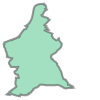

In [22]:
# load GeoJSON file containing sectors
data = json.load(open(lambeth))
polygon = shape(data['features'][0]['geometry'])
polygon

Ok so now we want to know how far each point is from the boundary of our polygon.  This is really complicated.... except there's a built in function for that!  We run through the list and create a list of all of the distances.  We can the create a Distribution Plot of these distances.

In [24]:
distances = []
for index, row in df.iterrows():
    point = Point(row['lon'],row['lat'])
    distances.append(polygon.boundary.distance(point))

 (0, 0.024365855504677923),

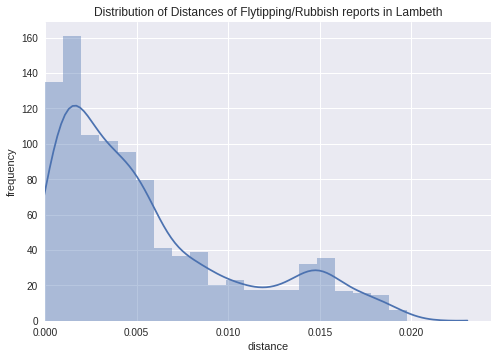

In [25]:
sns.set(color_codes=True)
sns.distplot(distances).set(xlim=(0, None),xlabel='distance', ylabel='frequency', title='Distribution of Distances of Flytipping/Rubbish reports in Lambeth')
plt.show()

## Comparing with a Randomised Data Set

Wow that looks pretty damning, but is it surprising?  With a complex shape like this, it's difficult to say how significant this is against a completely random dataset.  Again we could do some really complicated calculations to try and normalise the data, but it's much easier just to compare against a random data set.

So we can use the method below to try and create as many random points that in our dataframe lie within our polygon.  This is fairly crude, and won't scale up reliably, but it's suitable for our methods.

In [26]:
def generate_random(number, polygon):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

random_points = generate_random(len(distances),polygon)

Some nice list compregension to get our distances for each of the points.

In [29]:
random_distances = []
random_distances = [polygon.boundary.distance(x) for x in random_points]

Finally two more Distribution Plots, in two different styles with multiple series.  As you can see from both in the actual data, incidents are far more likely to be reported at the boundary of the Borough in the actual data set than in a comparitive randomised data set.  This might need some further consideration like population density, outliers etc.

 (0, 0.024365855504677923),

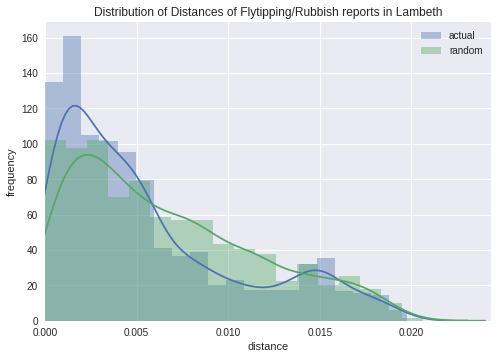

In [31]:
sns.set(color_codes=True)
sns.distplot(distances,label='actual').set(xlim=(0, None), xlabel='distance', ylabel='frequency', title='Distribution of Distances of Flytipping/Rubbish reports in Lambeth')
sns.distplot(random_distances,label='random')
plt.legend()
plt.show()

([array([ 644.,  435.,  378.,  158.,  120.,   76.,   99.,  128.,   66.,   21.]),
  array([ 430.,  417.,  295.,  268.,  210.,  180.,  119.,  101.,   85.,   20.])],
 array([  5.02802792e-07,   2.06161426e-03,   4.12272572e-03,
          6.18383718e-03,   8.24494864e-03,   1.03060601e-02,
          1.23671716e-02,   1.44282830e-02,   1.64893945e-02,
          1.85505059e-02,   2.06116174e-02]),
 <a list of 2 Lists of Patches objects>)

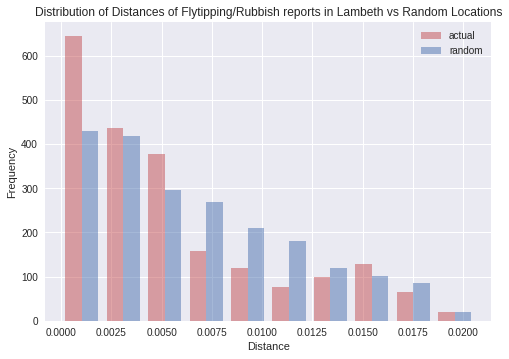

In [32]:
plt.hist([distances, random_distances], color=['r','b'], label=['actual','random'], alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances of Flytipping/Rubbish reports in Lambeth vs Random Locations')
plt.legend()
plt.show()

## Conclusion

The main things to take from this are mainly data science related!
* Jupyter/Docker are powerful tools for quickly standing up and managing data science projects in a consistent repeatable way.
* Leveraging existing data science libraries make complex problems simpler very quickly.  Standing on the shoulders of giants!
* Maps and Plots are really useful, pictures speak 1000 words.
* Sort out your borders, Lambeth!